In [219]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [186]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Статистические модели прогнозирования.

<AxesSubplot:xlabel='year'>

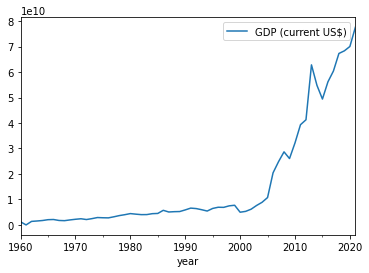

In [187]:
%matplotlib inline 
data.plot()

In [188]:
data.shape

(62, 1)

In [189]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

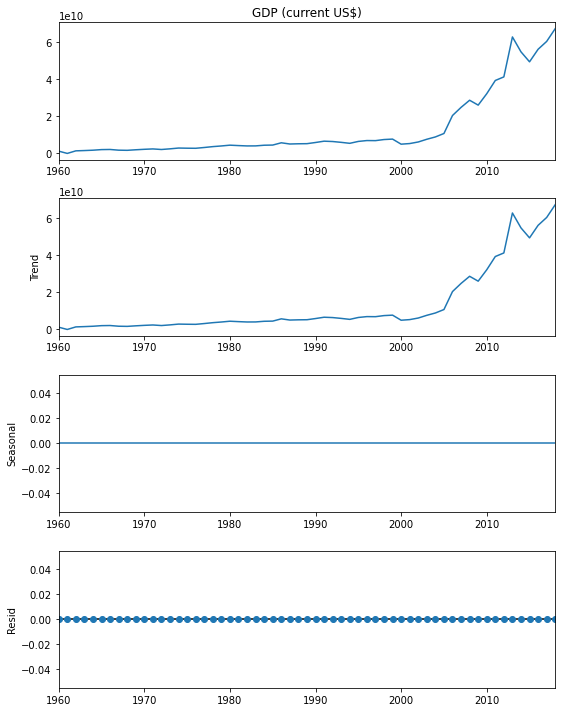

In [190]:
plt.rcParams["figure.figsize"] = 8, 10
result = seasonal_decompose(train_df['GDP (current US$)'], model='additive')
result.plot()
plt.show()

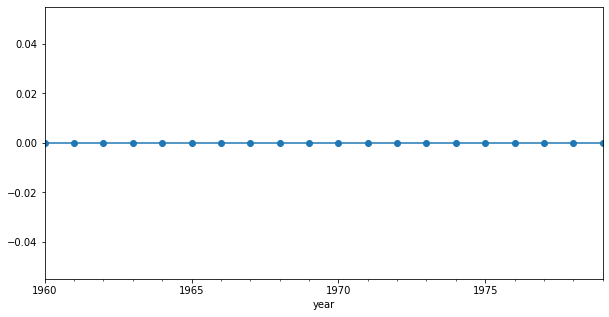

In [191]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "o")
plt.show()

По графику видно отсутствие сезонности. При этом отчетливо выражен возрастающий тренд. Данные представлены за каждый год, причем ВВП является макроэкономическим показателем, который не связан с сезонностью, а отражает общее экономическое состояние страны, которое как раз имеет динамику (тренд) роста, падения или стагнации.

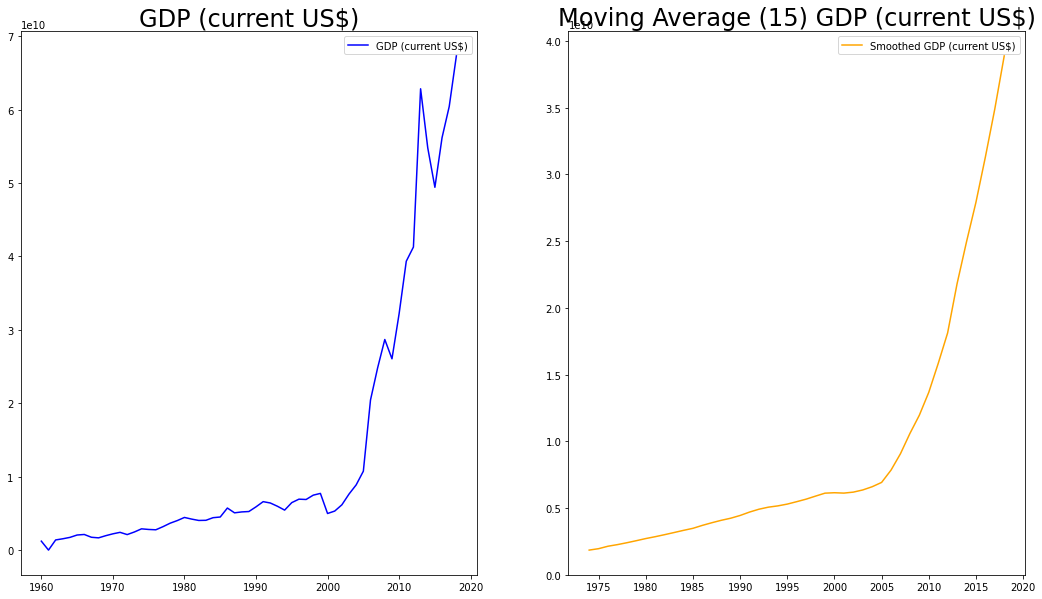

In [192]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(1, 2)

ax[0].plot(train_df['GDP (current US$)'], color = "blue", label = "GDP (current US$)")
ax[0].set_title("GDP (current US$)", size = 24)
ax[0].legend()

ax[1].plot(train_df['GDP (current US$)'].rolling(window=15).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[1].set_title("Moving Average (15) GDP (current US$)", size = 24)
ax[1].legend()

На графике выше справа отображена модель скользящего среднего (MA) с шириной окна сглаживания 10 лет. Поскольку скользящее среднее помогает избавить временной ряд от выбросов и лишнего шума, это упрощает визуальный анализ. На графике виден тренд роста ВВП Ганы. Причем до примерно 2000 года темп роста низкий, а после - высокий (кривая резко идет вверх).

In [194]:
test = adfuller(train_df['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  0.6529066974885378
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Временной ряд нестационарен


Так как временной ряд оказался нестационарным, необходимо его дифференцировать до тех пор, пока он не станет стационарным.

In [196]:
test = adfuller(train_df['GDP (current US$)'].diff(2).dropna())
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  -3.583670865826036
p-value:  0.006080989753876832
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Временной ряд стационарен


Так как временной ряд ВВП Ганы нестационарен, то принимаем решение об использовании модели ARIMA.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

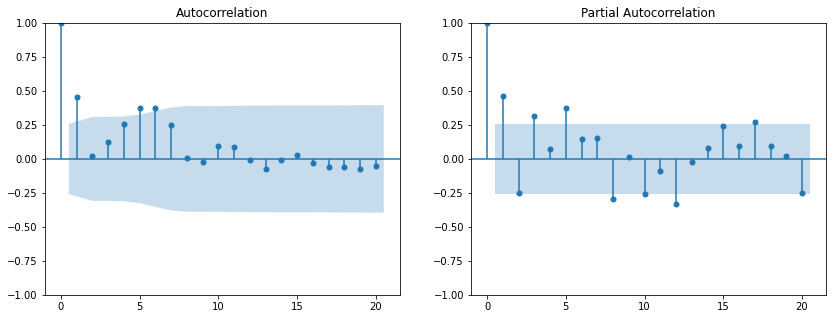

In [197]:
plt.rcParams['figure.figsize'] = 14, 5

fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[0])
sgt.plot_pacf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[1])
plt.show

Исходя из графиков автокорреляции и частичной автокорреляции выбираем параметры для модели p=1 и q=1.

In [198]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 18 Jan 2023   AIC                           2684.416
Time:                        22:01:57   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.95e+56. Standard errors may be unstable.
"""

In [199]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 18 Jan 2023   AIC                           2680.765
Time:                        22:02:01   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+55. Standard errors may be unstable.
"""

Наилучшие параметры для модели: ARIMA(1, 2, 3), - для которых коэффициент AIC меньше чем AIC для ARIMA(1, 2, 1) - 2680.765 < 2684.416.

In [200]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 18 Jan 2023   AIC                           2680.765
Time:                        22:03:31   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+55. Standard errors may be unstable.
"""

In [201]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

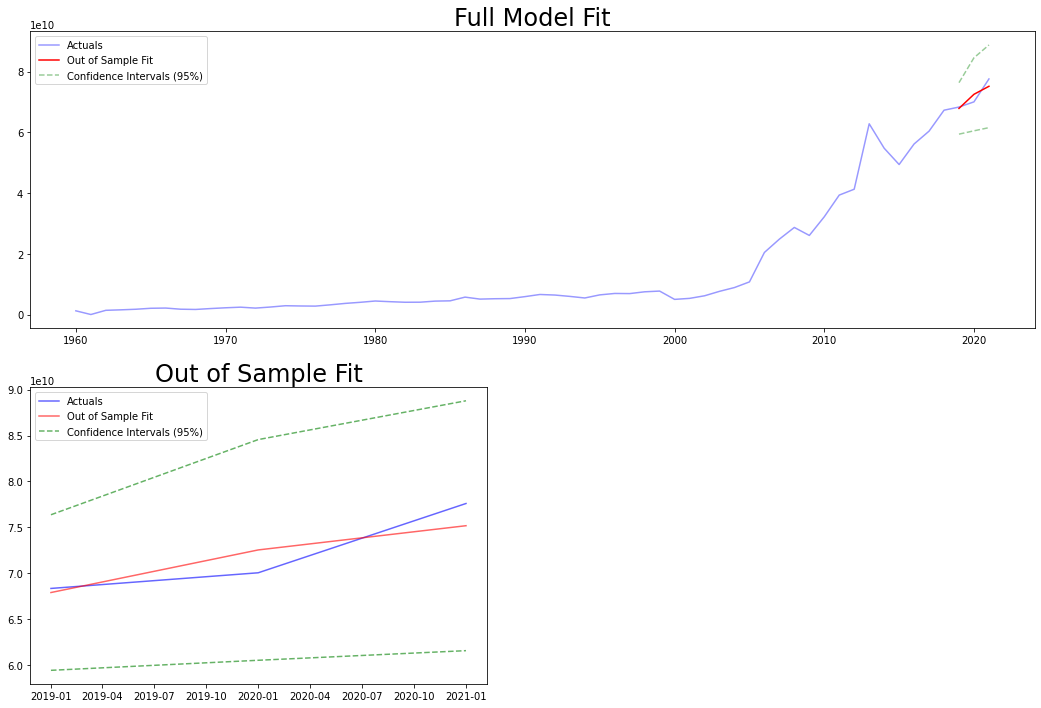

In [202]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Анализируя построенный выше график, можно сделать вывод, что построенная модель ARIMA(1, 2, 3) уловила динамику и тренд временного ряда и довольно близко предсказала значения ВВП Ганы за 2019-2021 годы к истинным значениям. Причем в 2019 году предсказание модели были наиболее близко к фактической величине.

Интерполяция и сэмплирование.

In [210]:
data_check = data.asfreq(freq='AS')

<AxesSubplot:xlabel='year'>

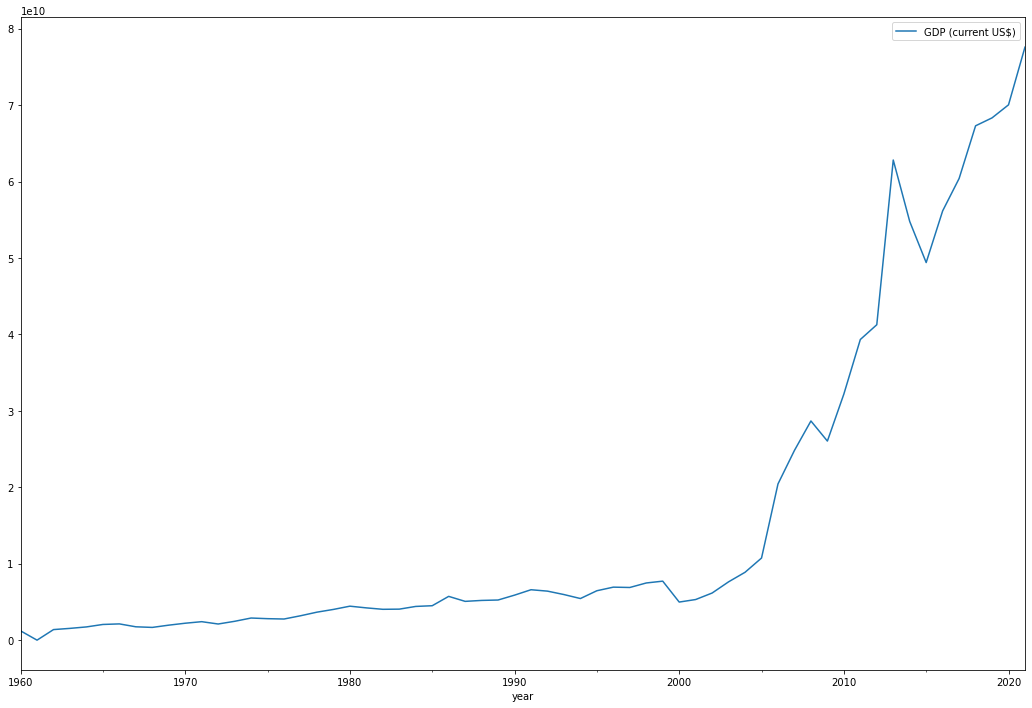

In [211]:
data_check.plot()

Пропущенных дат во временном ряде нет.

In [218]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Явных пропущенных значений во временном ряде нет.

In [220]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [221]:
data.isna().sum()

GDP (current US$)    1
dtype: int64

После заполнения нулей np.Nan был выявлен один пропуск.

In [226]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

In [227]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Пропущенное значение было заполнено с помощью интерполяции.

In [228]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [229]:
test = adfuller(train_df['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  0.8030073326980119
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Временной ряд нестационарен


Временной ряд нестационарен, следовательно проводим вычетание ряда до состояние стационарности с уровнем альфа 5%.

In [235]:
test = adfuller(train_df['GDP (current US$)'].diff(2).dropna())
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  -3.9998034409491567
p-value:  0.0014115408436660881
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Временной ряд стационарен


Так как временной ряд ВВП Ганы нестационарен, то будет использоваться модель ARIMA.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

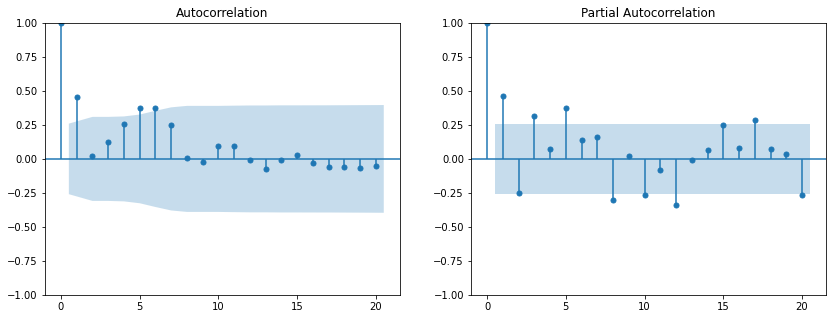

In [236]:
plt.rcParams['figure.figsize'] = 14, 5

fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[0])
sgt.plot_pacf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[1])
plt.show

По графикам автокорреляции и частичной автокорреляции определим p=1 и q=1.

In [237]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.188
Date:                Thu, 19 Jan 2023   AIC                           2684.377
Time:                        13:31:30   BIC                           2690.506
Sample:                    01-01-1960   HQIC                          2686.759
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      0.082     -2.127      0.033      -0.336      -0.014
ma.L1         -0.8690      0.046    -19.050      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22   9.21e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               277.83
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             480.68   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+57. Standard errors may be unstable.
"""

Подберем наилучшие параметры модели ARIMA.

In [238]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 19 Jan 2023   AIC                           2680.513
Time:                        13:31:54   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+55. Standard errors may be unstable.
"""

In [239]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 19 Jan 2023   AIC                           2680.513
Time:                        13:33:52   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+55. Standard errors may be unstable.
"""

Модель ARIMA на неинтерполированных данных: AIC=2680.765. Модель ARIMA на интерполированных данных: AIC=2680.513. Коэффициент улучшился, но незначительно, что логично, ведь пропущенное значение было только за один год из 62 лет. В остальном временной ряд остался прежним.